/var/folders/_7/42qnnz6j17g26jhlhv2l5_580000gn/T/ipykernel_13430/3080837209.py:62: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Lt = fsolve(F, Lt_guess)#, xtol=1E-8, maxfev=1000)#, factor=1, epsfcn=1E-6)
/var/folders/_7/42qnnz6j17g26jhlhv2l5_580000gn/T/ipykernel_13430/3080837209.py:62: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  Lt = fsolve(F, Lt_guess)#, xtol=1E-8, maxfev=1000)#, factor=1, epsfcn=1E-6)


0 299.9999999999709 -13.453566990715991 69.976313726938
4 299.9999999990687 99.51180799166625 -198.73720055389106
6 299.99999999953434 -72.92649180460333 152.53196939342791
7 299.99999999999994 3.0377895400337507 -0.8380354191815567
48 299.99999999999886 -66.18775874110929 1.3635142496979222
58 299.9999999999991 -65.48375929620832 1.3496544432134994
74 299.99999999999784 -62.83433654478049 1.2421227172006621
83 299.99999999999727 -63.723150963916744 1.2914041956986346
99 299.9999999999985 -65.16230017757002 1.3372583231236324
105 299.99999999999727 -63.75407668513182 1.2923759060282558
109 299.9999999999991 -63.8237230162583 1.2935727756260371
117 299.99999999999955 -66.83496309119455 1.372126500348789
123 299.99999999999727 -60.98083301311754 1.6791494243443272
126 299.9999999999994 -24.84011592999212 3.104118214012586
134 299.99999999999784 -71.49805799347635 1.4568978584615866
144 299.99999999999864 -37.15733878193517 2.385871278081267
146 299.99999999999943 -19.980541638760943 4.48

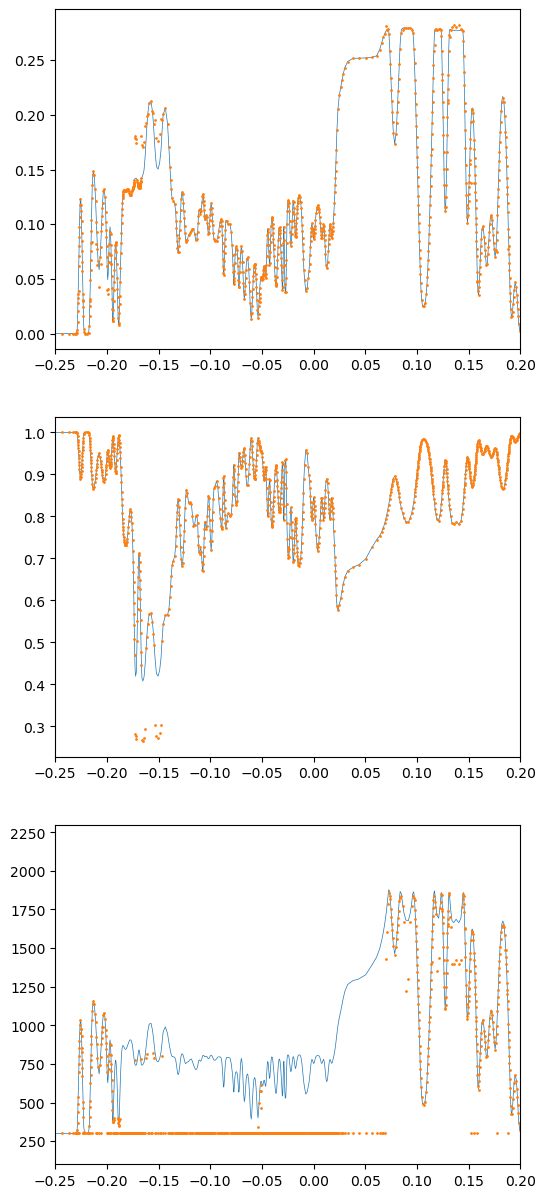

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.interpolate import LinearNDInterpolator as LNDI
from scipy.optimize import fsolve

#####################

nf = 100
nL = 36
nt = 21

fgrid = np.linspace(0,1,nf)            # table coordinates
Lgrid = np.arange(nL, dtype=np.float64)
tgrid = np.arange(nt, dtype=np.float64)

c = np.zeros((nf, nL, nt))
h = np.zeros((nf, nL, nt))
T = np.zeros((nf, nL, nt))

###################################

for iL in range(nL):
    for it in range(nt):
        fname = "flm_" + str(iL).zfill(2) + '_' + str(it).zfill(2) + ".dat"
        data = np.loadtxt(fname)

        ii = interp1d(data[:,1], data[:,4])       # mixf, c
        c[:,iL, it] = ii(fgrid)

        ii = interp1d(data[:,1], data[:,3])       # mixf, h
        h[:,iL, it] = ii(fgrid)

        ii = interp1d(data[:,1], data[:,2])       # mixf, T
        T[:,iL, it] = ii(fgrid)

#####################

hmax = np.max(h)
hmin = np.min(h)
h = (h-hmin)/(hmax-hmin)

#####################

cI = RGI((fgrid, Lgrid, tgrid), c, bounds_error=False, fill_value=None, method='linear')      # call as cI([fvalue, Lvalue, tvalue])
hI = RGI((fgrid, Lgrid, tgrid), h, bounds_error=False, fill_value=None, method='linear')      
TI = RGI((fgrid, Lgrid, tgrid), T, bounds_error=False, fill_value=None, method='linear')

#####################

def get_Lt(f, h, c, Lt_guess=np.array([0.0,7.0])):

    def F(Lt):
        L = Lt[0]
        t = Lt[1]
        F0 = hI([f, L, t])[0] - h
        F1 = cI([f, L, t])[0] - c
        return np.array([F0, F1])

    Lt = fsolve(F, Lt_guess)#, xtol=1E-8, maxfev=1000)#, factor=1, epsfcn=1E-6)
    
    L = Lt[0]
    t = Lt[1]
    #if L<Lgrid[0]:  L=Lgrid[0]
    #if L>Lgrid[-1]: L=Lgrid[-1]
    #if t<tgrid[0]:  t=Lgrid[0]
    #if t>tgrid[-1]: t=Lgrid[-1]
    return L, t

#####################

#L, t = get_Lt(0.05045, -7.3E5, 0.0517)
#print(L,t)

#####################

#odt = np.loadtxt('../table/data_adia/dmp_00016.dat')    # 16, 23
odt = np.loadtxt('../table/data_radi/dmp_00012.dat')     # 9, 10, 11, 12
xodt = odt[:,0]
Todt = odt[:,7]
hodt = (odt[:, 28]-hmin)/(hmax-hmin)
codt = odt[:, 11] + odt[:,16] + odt[:,22] + odt[:,23]
fodt = odt[:,8]
fodt[fodt<0.0] = 0.0; fodt[fodt>1.0] = 1.0

nodt = len(fodt)
TT = np.zeros(nodt)
cc = np.zeros(nodt)
hh = np.zeros(nodt)
Lt_guess = np.array([1.0, 2.0])
for i in range(nodt):
    L, t = get_Lt(fodt[i], hodt[i], codt[i], Lt_guess)
    TT[i] = TI([fodt[i], L, t])[0]
    cc[i] = cI([fodt[i], L, t])[0]
    hh[i] = hI([fodt[i], L, t])[0]
    #TT[i] = TI([fodt[i], L, 0])[0]               # forces adiabatic 
    #Lt_guess = np.array([L, t])
    
    #if i%10==0: print(L,t)
    #if i%20==0: print(np.abs((codt[i]-cc[i])/codt[i]))
    #if i%20==0: print(i, hI([fodt[i],L,t])[0]-hodt[i], cI([fodt[i],L,t])[0]-codt[i])
    #if i%2==0: print(i, L, t, hI([fodt[i],L,t])[0], hodt[i], cI([fodt[i],L,t])[0],codt[i])
    if TT[i] < 300: print(i,TT[i], L,t)

#------------------------

dof = False

plt.figure(figsize=(6,15))
plt.subplot(3,1,1)
plt.plot(fodt if dof else xodt, codt, '-', lw=0.5)
plt.plot(fodt if dof else xodt, cc, 'o', ms=1, lw=0.5)
if not dof: plt.xlim([-0.25,0.2])

plt.subplot(3,1,2)
plt.plot(fodt if dof else xodt, hodt, '-', lw=0.5)
plt.plot(fodt if dof else xodt, hh, 'o', ms=1, lw=0.5)
if not dof: plt.xlim([-0.25,0.2])

plt.subplot(3,1,3)
plt.plot(fodt if dof else xodt, Todt, '-', lw=0.5)
plt.plot(fodt if dof else xodt, TT, 'o', ms=1, lw=0.5)
if not dof: plt.xlim([-0.25,0.2])
plt.ylim([100,2300])